In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
pd.set_option('display.max_columns', 20)
pd.set_option('display.max_rows', 60)
target ='Demanda_uni_equil'
dtypes_train = {'Semana': np.int8, 'Agencia_ID': np.int32, 'Canal_ID': np.int8, 'Ruta_SAK':np.int16 ,'Cliente_ID': np.int32,
                'Producto_ID': np.uint16,'Demanda_uni_equil': np.float16,
                'Demanda_uni_equil2': np.float16,'Demanda_uni_equil3': np.float16,'Demanda_uni_equil4': np.float16}


col = [ 'Semana','Agencia_ID','Canal_ID','Ruta_SAK','Cliente_ID','Producto_ID','Demanda_uni_equil2','Demanda_uni_equil3','Demanda_uni_equil4','Demanda_uni_equil']
col2 = [ 'Semana','Agencia_ID','Ruta_SAK','Cliente_ID','Producto_ID','Demanda_uni_equil']
col2 = [ 'Semana','Cliente_ID','Producto_ID','Demanda_uni_equil']
data = pd.read_csv('train.csv', header=0,dtype  = dtypes_train,
                   usecols = col2,nrows=22174801)


In [2]:
data = pd.read_csv('./train34.csv.gz',compression='gzip', header=0,dtype  = dtypes_train,
                   usecols = col2,nrows=22174801)

In [3]:
# confirm dataset contains week3 and week4 data
print (data.groupby(['Semana']).apply(len))

Semana
3    11165207
4    11009593
5           1
dtype: int64


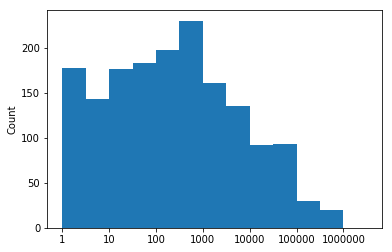

1637
956
22174801 before removing ptds
22158903 after removing ptds


22

In [4]:
pdts = data.groupby('Producto_ID').apply(len).reset_index(drop=False)
if True:
    bins = np.linspace(0,6.5,14)
    plt.hist(np.log10(pdts[0]),bins);
    plt.xticks(bins[::2],map(int,10**bins[::2]))
    plt.ylabel('Count')
    plt.show()

print (len(pdts)),
pdts = pdts[pdts[0]>100].reset_index(drop=True)
print (len(pdts))
print (len(data),'before removing ptds')
data = pd.merge(data,pdts[['Producto_ID']],'inner')
# do not consider amount brought, only consider if they are brought together as a first approximation
data[target] = (data[target]*0+1).astype(np.uint8)
print (len(data),'after removing ptds')
data = data.drop_duplicates().iloc[::1]
#data2= data[data['Agencia_ID']==1110]
#data2.groupby(['Cliente_ID','Producto_ID']).apply(len)
products = sorted(pd.unique(data['Producto_ID']))
clients = sorted(pd.unique(data['Cliente_ID']))
clients_dict=  {}
products_dict= {}
for i in range(len(products)):
    products_dict[products[i]] = i
for i in range(len(clients)):
    clients_dict[clients[i]] = i
data['Producto_ID']=data['Producto_ID'].map(products_dict)
data['Cliente_ID']=data['Cliente_ID'].map(clients_dict)
import gc
gc.collect()
import itertools
data3 = data[data['Semana']==3]
data4 = data[data['Semana']==4].reset_index(drop=True)
del data
gc.collect()


In [5]:
if False: #get co-occurnece matrix, where each element in matrix is the occurence of item i and j being brought
    # at the same time
    mat = np.zeros((len(products),len(products))).astype(np.float32)
    num_pdts =  len(products_dict)

    ids = pd.unique(data3['Cliente_ID'])
    skip = 55000
    for i in range(0,len(ids),skip):
        print (i)
        ids_subset = ids[i:i+skip]
        #faster method by matrix multiplication, but memoery intensive
        zz=data3[data3['Cliente_ID'].isin(ids_subset)].pivot(
            index='Cliente_ID',
            columns='Producto_ID',
            values=target).fillna(0).astype(np.uint8)
        for i in range(num_pdts):
            try:
                temp= zz.iloc[:5][i]
            except KeyError :
                zz[i] =0
        zz = zz[np.array(range(num_pdts))].values
        zzz = np.matmul(zz.T,zz)
        mat += zzz
        gc.collect()
    np.save('mat.npy',mat)
mat = np.load('mat.npy')

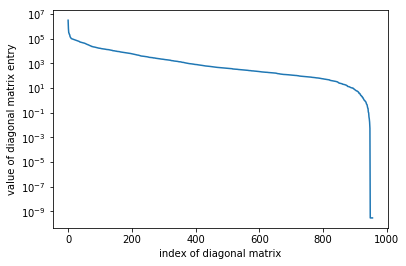

In [6]:
#matrix factorization
v,d,vt=np.linalg.svd(mat)
plt.plot(d);plt.yscale('log');plt.xlabel('index of diagonal matrix')
plt.ylabel('value of diagonal matrix entry')
plt.show()

In [161]:
#get names of products instead of using indexes
producto_tabla = pd.read_csv('producto_tabla.csv')
producto_tabla = pd.merge(pdts,producto_tabla)
producto_tabla['product_id'] = producto_tabla['Producto_ID'].map(products_dict)
print (producto_tabla.head())

   Producto_ID      0                       NombreProducto  product_id
0           72  38390  Div Tira Mini Doradita 4p 45g TR 72           0
1           73  62070    Pan Multigrano Linaza 540g BIM 73           1
2          106    970   Wonder 100pct mediano 475g WON 106           2
3          123   3674     Super Bollos 5in 8p 540g WON 123           3
4          131    139       Bollos BK 4in 36p 1635g SL 131           4


In [108]:
#getting product embeddings
if True:
    j = 5
    error = np.mean((np.matmul(np.matmul(v[:,:j],np.diag(d[:j])),vt[:j,:])-mat)**2)
    SSTO = np.mean(mat**2)
    print ('looks like dimentions of %s is enough, ERROR =='%j ,error/SSTO,'%')
    item_vector = v[:,:j]*(d[:j]**.5)
    print (np.mean((np.matmul(item_vector,item_vector.T)-mat)**2)/SSTO)
    vec = v[:,:j]/np.expand_dims(np.sum(v[:,:j]**2,1)**.5,1)
    vec = np.nan_to_num(vec,0)
    cos_dist_mat = np.abs(np.nan_to_num(np.matmul(vec,vec.T),0))
    


looks like dimentions of 5 is enough, ERROR == 0.03377431 %
0.03377431


/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:9: RuntimeWarning: invalid value encountered in true_divide
  if __name__ == '__main__':


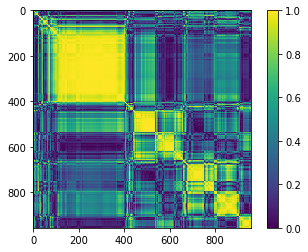

In [9]:
if True:
    from matplotlib.colors  import LogNorm
    from scipy.cluster.hierarchy import dendrogram, linkage 
    plt.close()
    fig,ax = plt.subplots(1,1,figsize=(20,7))
    linked = linkage(cos_dist_mat , 'single')
    dendro  = dendrogram(linked, 
                orientation='top',
                labels=list(producto_tabla.NombreProducto),
                distance_sort='descending',
                show_leaf_counts=True,color_threshold=15)
    import matplotlib.pyplot as plt
    plt.tight_layout(rect=[0.025, 0.025, .94, .94]);
    plt.title('Hierarchical Clustering of\nQuantitive Variables from abs|correlation matrix|')
    plt.ylabel('Distance');plt.xlabel('Quantitive Variables')
    plt.xticks(np.array(range(len(list(producto_tabla.NombreProducto))))*10,
               list(producto_tabla.NombreProducto),fontsize=0.5);plt.savefig('Cluster.png',dpi=500);plt.close()
    a=plt.imshow(cos_dist_mat[np.array(dendro['leaves']),:][:,np.array(dendro['leaves'])]);plt.colorbar(a);plt.show()

In [10]:
from scipy import cluster
clusters_n = cluster.hierarchy.cut_tree(linked,height=[2,3,4,5])

In [162]:
producto_tabla['cluster2'] = clusters_n[:,0]
producto_tabla['cluster3'] = clusters_n[:,1]
producto_tabla['cluster4'] = clusters_n[:,2]
producto_tabla['cluster5'] = clusters_n[:,3]
producto_tabla.sort_values('cluster2')

,Producto_ID,0,NombreProducto,product_id,cluster2,cluster3,cluster4,cluster5
0,72,38390,Div Tira Mini Doradita 4p 45g TR 72,0,0,0,0,0
310,32132,2103,Salmas Maiz Horn 108g CJM SAN 32132,310,0,0,0,0
325,32322,13517,Tortilla Hna RB 10p 260g Prom DH 32322,325,0,0,0,0
341,32802,33659,Tortillas de Maiz 800g MR 32802,341,0,0,0,0
343,32819,50518,Chocodonitas 6p 102g BIM 32819,343,0,0,0,0
347,32846,4551,Decanelas 5 Obleas 83g SP MTB LAR 32846,347,0,0,0,0
354,32873,23241,Canapinas 140g SP MTA LAR 32873,354,0,0,0,0
293,31720,11435,Mantecadas Chocolate 2p 95g TR 31720,293,0,0,0,0
394,33734,6591,Galleta Avena Chispas 8p 100g TR 33734,394,0,0,0,0
472,35141,31196,Super Pan Blanco Ajonjoli 567g WON 35141,472,0,0,0,0


In [141]:
def get_var_of_purchases(x):
    #get average rms distance from medoid, quanitfy spread of purchaces
    y = np.mean(np.sum((vec[x==1]-np.mean(vec[x==1],0))**2,1)**.5)
    return y

In [145]:
list(map(get_var_of_purchases,client_purchases_wk3.iloc[:2].values))

[0.69628334, 0.8579779]

In [72]:
ids = pd.unique(data3['Cliente_ID'])
ids_subset = ids[:50000]
num_pdts =  len(products_dict)
#analyzing first 100k clients due to memory issues
data3_first100k = data3[data3['Cliente_ID'].isin(ids_subset)]
data4_first100k = data4[data4['Cliente_ID'].isin(ids_subset)]
data4_first100k = data4_first100k[data4_first100k['Cliente_ID'].isin(data3_first100k['Cliente_ID'].values)]
data3_first100k = data3_first100k[data3_first100k['Cliente_ID'].isin(data4_first100k['Cliente_ID'].values)]
gc.collect()
client_purchases_wk3=data3_first100k.pivot(
            index='Cliente_ID',
            columns='Producto_ID',
            values=target).fillna(0).astype(np.uint8)
client_purchases_wk4=data4_first100k.pivot(
            index='Cliente_ID',
            columns='Producto_ID',
            values=target).fillna(0).astype(np.uint8)
for i in range(num_pdts):
            try:
                temp= client_purchases_wk3.iloc[:5][i]
            except KeyError :
                client_purchases_wk3[i] =0
                client_purchases_wk3[i] = client_purchases_wk3[i].astype(np.uint8)
client_purchases_wk3 = client_purchases_wk3[np.array(range(num_pdts))]
for i in range(num_pdts):
            try:
                temp= client_purchases_wk4.iloc[:5][i]
            except KeyError :
                client_purchases_wk4[i] =0
                client_purchases_wk4[i] = client_purchases_wk4[i].astype(np.uint8)

client_purchases_wk4 = client_purchases_wk4[np.array(range(num_pdts))]
gc.collect()

250

In [183]:
def get_var_of_purchases(x):
    #get average rms distance from medoid, quanitfy spread of purchaces, if they occupy same or diff criteria
    y = np.mean(np.sum((vec[x==1]-np.mean(vec[x==1],0))**2,1)**.5)
    return y
client_purchases_wk3['spread_purchases'] = list(map(get_var_of_purchases,client_purchases_wk3.values[:,:len(pdts)]))
client_purchases_wk4['spread_purchases'] = list(map(get_var_of_purchases,client_purchases_wk4.values[:,:len(pdts)]))


0.7550432616397189


In [187]:

vec_cluster0 = vec[producto_tabla[producto_tabla['cluster5']==0].index]
print (np.mean(client_purchases_wk3['spread_purchases'] ))
print (np.mean(np.sum((vec_cluster0 - np.mean(vec_cluster0,0))**2,1)**.5))

0.7550432616397189
0.79082936


In [74]:
acc=client_purchases_wk4*(client_purchases_wk4.values == client_purchases_wk3.values)


In [63]:
#client id==0 purchaed these items in week4
a = client_purchases_wk4.iloc[0][client_purchases_wk4.iloc[0]==1].index
b = client_purchases_wk3.iloc[0][client_purchases_wk3.iloc[0]==1].index

print (a,b)

Int64Index([ 33,  34,  53,  55,  58,  61,  62,  63,  64,  66,  67, 216, 420,
            504, 632, 665, 710, 715, 787, 883],
           dtype='int64', name='Producto_ID') Int64Index([31, 33, 37, 53, 55, 58, 62, 63, 64, 66, 68, 504, 883], dtype='int64', name='Producto_ID')


In [66]:
print (set(list(a)).intersection(list(b)))
print (10./len(a))

{64, 33, 66, 883, 53, 55, 504, 58, 62, 63}
0.5


In [60]:
len(set(list(a)).intersection(list(b)))

35

In [104]:
print (np.mean(np.sum(acc.iloc[:],1)/np.sum(client_purchases_wk4.iloc[:],1)))

0.7220867084314196


In [78]:
client_embeddings = np.matmul(client_purchases_wk3,np.nan_to_num(vec,0))
print (client_embeddings.shape)
gc.collect()

(49356, 5)


73

In [81]:
client_next_purchase= np.matmul(client_embeddings[:,],np.nan_to_num(vec,0).T)

In [86]:
client_next_purchase = client_purchases_wk4*0 +client_next_purchase 


AttributeError: module 'numpy' has no attribute 'percetile'

In [91]:
np.percentile(client_next_purchase,98,1)

array([ 7.0161726 , 15.66638536,  5.85316553, ..., 11.8579565 ,
       17.46321678, 37.97332993])

20

In [94]:
acc_recommend=client_purchases_wk4*(client_next_purchase.values >= np.expand_dims(np.percentile(client_next_purchase,98,1),1))


In [105]:
np.mean(np.sum(acc_recommend,1)/20)

0.20858659534808333